# 1 - Introduction

Hello, I'm Naufal. This is the notebook for my first natural language processing project. The dataset is called AG's corpus of news articles, can be downloaded from here https://course.fast.ai/datasets. It is a collection of news articles gathered from more than 2000 news sources by an academic news search engine (ComeToMyHead). I will construct a NLP model to classify the news articles into four categories.

---
# 2 - Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random, re, string, nltk, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, TextVectorization, LSTM, GRU, Dot, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Naufal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

---
# 3 - Data Loading

In [2]:
train = pd.read_csv('ag_news_csv/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('ag_news_csv/test.csv', header=None, names=['label', 'title', 'description'])

train1 = train.copy()
test1 = test.copy()

print('Shape of the train set (row, column) : ', train.shape)
print('Shape of the test set (row, column) : ', test.shape)
train.head()

Shape of the train set (row, column) :  (120000, 3)
Shape of the test set (row, column) :  (7600, 3)


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


The dataset has been split into two, the train and the test set. Both have 3 columns and combined have 127,600 rows.

* Column label: the label or class of the news
* Column title: the title of the news
* Column description: the description of the news

In [3]:
train['label'].unique()

array([3, 4, 2, 1], dtype=int64)

There are 4 labels in the dataset. They are the indicators of the news topic. 
* Label 1: News about the World
* Label 2: News about Sports
* Label 3: News about Business
* Label 4: News about Sci/Tech

Column label is the target for our model. Our predictive model will be used to predict the label of the news.

We would like to change the value so it starts from 0. This way, the modeling process can be easier.

In [4]:
train['label'] = train['label'].replace({1:0, 2:1, 3:2, 4:3})
test['label'] = test['label'].replace({1:0, 2:1, 3:2, 4:3})

In [5]:
train.head()

,label,title,description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


This is what we have now:
* Label 0: News about the World
* Label 1: News about Sports
* Label 2: News about Business
* Label 3: News about Sci/Tech

In [8]:
# For loop to check 5 random data
random_index = random.randint(0, len(train) - 5)
for row in train[['title', "label", 'description']][random_index:random_index + 5].itertuples():
  _, title, target, desc = row
  if target == 0:
    print(f"Label : {target} - World News")
  elif target == 1:
    print(f"Label : {target} - Sports News")
  elif target == 2:
    print(f"Label : {target} - Business News")
  elif target == 3:
     print(f"Label : {target} - Sci/Tech News")
  print(f"Title: {title}")
  print(f'Description: {desc}')
  print("---------------------------------"*5)

Label : 3 - Sci/Tech News
Title: Sony begins sampling Blu-ray components
Description: With the next-generation DVD race hotting up, Sony says that it will begin sampling optical pick-ups featuring blue laser diodes in December this year.
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Label : 3 - Sci/Tech News
Title: Digital music  #39;niche #39; market for foreseeable future, won #39;t replace &lt;b&gt;...&lt;/b&gt;
Description: While digital music revenues will grow to be eight per cent of the total European music market by 2009, the CD will remain the bedrock of music sales, according to a new report by market analysts Jupiter Research.
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Label : 3 - Sci/Tech News
Title: Nortel Will Cut 3,250 Jobs, 250 Few

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   title        120000 non-null  object
 2   description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [8]:
train.isnull().sum().sum()

0

No missing value is detected

---
# 4 - Exploratory Data Analysis (EDA)

### Descriptive Statistics

In [9]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
label,120000.0,NaN,NaN,NaN,1.5,1.118039,0.0,0.75,1.5,2.25,3.0
title,120000,114364,Today's schedule,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,120000,118731,"With the economy slowly turning up, upgrading ...",15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


News with title "Today's schedule" appeared the most with a count of 39. 

### Class Distribution

2    30000
3    30000
1    30000
0    30000
Name: label, dtype: int64


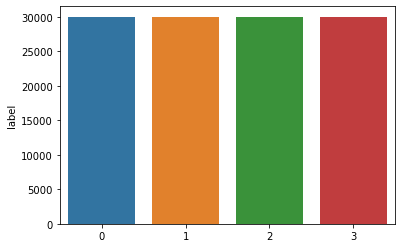

In [10]:
x = train['label'].value_counts()
print(x)
sns.barplot(x.index, x);

The dataset is balanced. Every class has the same number of articles (30,000)

### Number of words

We would like to count the number of words in the title and description of the news. Each word is separated by a space.

In [11]:
train['word_title'] = train['title'].apply(lambda x: len(x.split(' ')))  # number of words in title
train['word_description'] = train['description'].apply(lambda x: len(x.split(' '))) # number of words in description
train.head()

,label,title,description,word_title,word_description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24


In [12]:
for label in ['World', 'Sports', 'Business', 'Sci/Tech']:
    print(f'Average word count in the title of {label} news:', train[train['label'] == label]['word_title'].mean())


Average word count in World news title 7.285
Average word count in Sports news title 6.451033333333333
Average word count in Business news title 6.832233333333333
Average word count in Sci/Tech news title 6.6952


In [13]:
for label in ['World', 'Sports', 'Business', 'Sci/Tech']:
    print(f'Average word count in the description of {label} news:', train[train['label'] == label]['word_description'].mean())

Average word count in World news description 32.20256666666667
Average word count in Sports news description 31.7329
Average word count in Business news description 31.544233333333334
Average word count in Sci/Tech news description 30.931733333333334


* World news has the longest average word count, both in title and description.

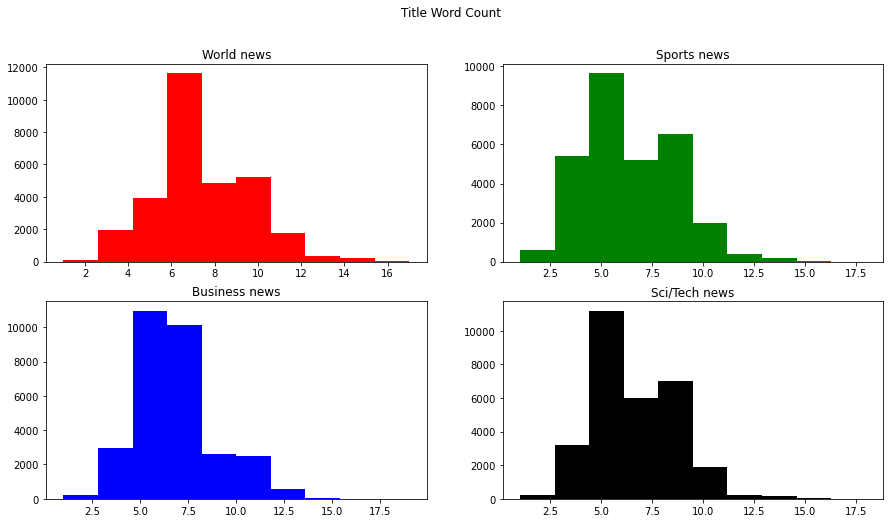

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('\'Title\' Word Count')

for ax, label in zip(axes.flatten(), ['World', 'Sports', 'Business', 'Sci/Tech']):
    train_words = train[train['label'] == label]['word_title']
    ax.hist(train_words, color='C0')
    ax.set_title(f'{label} news')

plt.show()


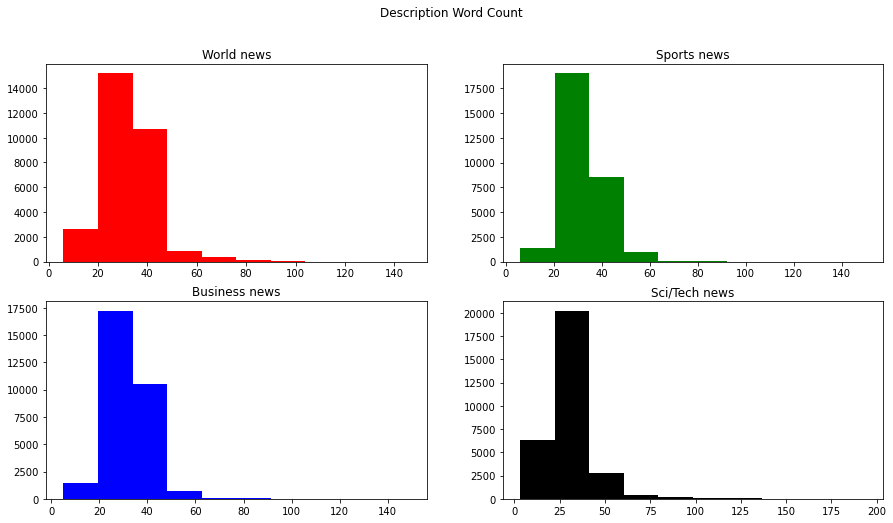

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('\'Description\' Word Count')

for ax, label in zip(axes.flatten(), ['World', 'Sports', 'Business', 'Sci/Tech']):
    train_words = train[train['label'] == label]['word_description']
    ax.hist(train_words, color='C0')
    ax.set_title(f'{label} news')

plt.show()


### Number of characters

In [16]:
train['char_title'] = train['title'].apply(lambda x: len(str(x)))  # number of characters in title
train['char_description'] = train['description'].apply(lambda x: len(str(x))) # number of characters in description
train.head()

,label,title,description,word_title,word_description,char_title,char_description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12,49,94
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30,51,214
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29,47,184
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27,60,195
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24,73,160


In [17]:
print('Average character count in World news title',train[train['label'] == 0]['char_title'].mean())
print('Average character count in Sports news title',train[train['label'] == 1]['char_title'].mean())
print('Average character count in Business news title',train[train['label'] == 2]['char_title'].mean())
print('Average character count in Sci/Tech news title',train[train['label'] == 3]['char_title'].mean())

Average character count in World news title 45.73276666666667
Average character count in Sports news title 38.48083333333334
Average character count in Business news title 41.7183
Average character count in Sci/Tech news title 42.370133333333335


In [18]:
print('Average character count in World news description',train[train['label'] == 0]['char_description'].mean())
print('Average character count in Sports news description',train[train['label'] == 1]['char_description'].mean())
print('Average character count in Business news description',train[train['label'] == 2]['char_description'].mean())
print('Average character count in Sci/Tech news description',train[train['label'] == 3]['char_description'].mean())

Average character count in World news description 195.8939
Average character count in Sports news description 185.17136666666667
Average character count in Business news description 198.69026666666667
Average character count in Sci/Tech news description 193.85253333333333


* World news has the longest average title character count.
* Business news has the longest average description character count. 

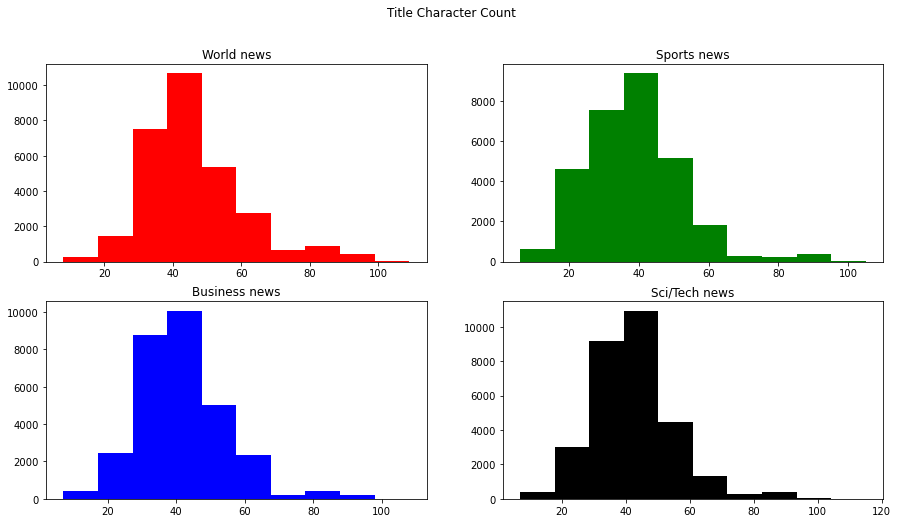

In [19]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
fig.suptitle('Title Character Count')

train_char = train[train['label']==0]['char_title']
axes[0,0].hist(train_char,color='red')
axes[0,0].set_title('World news')

train_char = train[train['label']==1]['char_title']
axes[0,1].hist(train_char,color='green')
axes[0,1].set_title('Sports news')

train_char = train[train['label']==2]['char_title']
axes[1,0].hist(train_char, color='blue')
axes[1,0].set_title('Business news')

train_char = train[train['label']==3]['char_title']
axes[1,1].hist(train_char, color='black')
axes[1,1].set_title('Sci/Tech news')

plt.show()

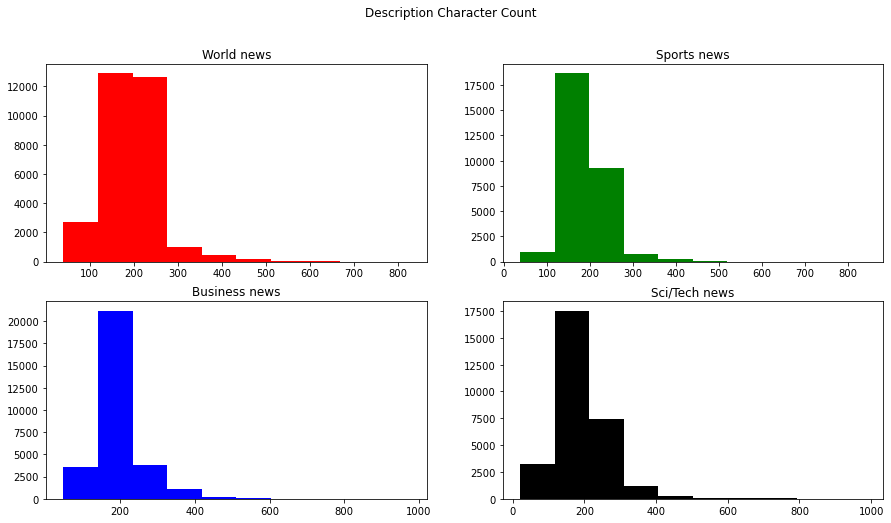

In [20]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
fig.suptitle('Description Character Count')

train_char = train[train['label']==0]['char_description']
axes[0,0].hist(train_char,color='red')
axes[0,0].set_title('World news')

train_char = train[train['label']==1]['char_description']
axes[0,1].hist(train_char,color='green')
axes[0,1].set_title('Sports news')

train_char = train[train['label']==2]['char_description']
axes[1,0].hist(train_char, color='blue')
axes[1,0].set_title('Business news')

train_char = train[train['label']==3]['char_description']
axes[1,1].hist(train_char, color='black')
axes[1,1].set_title('Sci/Tech news')

plt.show()

---
# 5 - Data Preprocessing

### Case folding, stopword removal, and lemmatization

In order to help the model, we would like to do case folding (convert to lowercase, strip, etc), remove the stopwords, and lemmatize the words. We will use the NLTK library to do this.

In [21]:
# convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() # lower case
    text = text.strip()  # remove leading and trailing spaces
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) # remove punctuations  
    text = re.sub('\s+', ' ', text) # remove extra spaces 
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip()) # remove special characters
    text = re.sub(r'\d',' ',text) # remove digits
    
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# LEMMATIZATION
wl = WordNetLemmatizer()
 
# Helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [22]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [23]:
train['clean_desc'] = train['description'].apply(lambda x: finalpreprocess(x))

In [24]:
train['clean_title'] = train['title'].apply(lambda x: finalpreprocess(x))

In [25]:
test['clean_desc'] = test['description'].apply(lambda x: finalpreprocess(x))

In [26]:
test['clean_title'] = test['title'].apply(lambda x: finalpreprocess(x))

In [27]:
train[['title', 'clean_title', 'description', 'clean_desc']].head()

,title,clean_title,description,clean_desc
0,Wall St. Bears Claw Back Into the Black (Reuters),wall st bear claw back black reuters,"Reuters - Short-sellers, Wall Street's dwindli...",reuters short seller wall street dwindle band ...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look toward commercial aerospace reuters,Reuters - Private investment firm Carlyle Grou...,reuters private investment firm carlyle group ...
2,Oil and Economy Cloud Stocks' Outlook (Reuters),oil economy cloud stock outlook reuters,Reuters - Soaring crude prices plus worries\ab...,reuters soar crude price plus worry economy ou...
3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...,Reuters - Authorities have halted oil export\f...,reuters authority halt oil export flow main pi...
4,"Oil prices soar to all-time record, posing new...",oil price soar time record pose new menace u e...,"AFP - Tearaway world oil prices, toppling reco...",afp tearaway world oil price toppling record s...


The result of the preprocessing can be seen above.

### Split between features and target

In [28]:
X_train = train[['clean_title', 'clean_desc']]
y_train = train['label']
X_test = test[['clean_title', 'clean_desc']]
y_test = test['label']

### Extract data for model inference

In [29]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [30]:
print('Shape of the train set (row, column) : ', X_train.shape)
print('Shape of the validation set (row, column) : ', X_val.shape)
print('Shape of the test set (row, column) : ', X_test.shape)

Shape of the train set (row, column) :  (108000, 2)
Shape of the validation set (row, column) :  (12000, 2)
Shape of the test set (row, column) :  (7600, 2)


* We will train our model on the train set, and validate the model on the validation set. 
* The test set will be used for model inference

### Tokenization

In [31]:
round(sum([len(i.split()) for i in X_train.clean_title]) / len(X_train.clean_title))

6

In [32]:
round(sum([len(i.split()) for i in X_train.clean_desc]) / len(X_train.clean_desc))

20

In [33]:
max_vocab_length = 3500
max_length_title = 6
max_length_desc = 20

In [34]:
# setup vect
text_vectorization_title = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length_title,
                                       input_shape=(1,) 
                                       )

In [35]:
text_vectorization_title.adapt(X_train.clean_title)

In [36]:
text_vectorization_desc = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length_desc,
                                       input_shape=(1,) 
                                       )

In [37]:
text_vectorization_desc.adapt(X_train.clean_desc)

In [38]:
# Embedding layer
embedding_title = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length_title, name='Title-Embedding'
                      )

In [39]:
embedding_desc = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length_desc, name='Desc-Embedding'
                      )

### Target Encoding

In [40]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

### Data pipeline

In [41]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.clean_title, X_train.clean_desc, y_train_ohe))
val_data = tf.data.Dataset.from_tensor_slices((X_val.clean_title, X_val.clean_desc, y_val_ohe))
test_data = tf.data.Dataset.from_tensor_slices((X_test.clean_title, X_test.clean_desc, y_test_ohe))

---
# 6 - Model Definition

## Model 1 

Model 1 architecture includes a Global Average Pooling 1D layer.

In [42]:
title_in = Input(shape=(1,), dtype="string", name='Title-Input')
title_vec = text_vectorization_title(title_in)
title_emb = embedding_title(title_vec)
title_x = GlobalAveragePooling1D()(title_emb)

desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
desc_vec = text_vectorization_desc(desc_in)
desc_emb = embedding_desc(desc_vec)
desc_x = GlobalAveragePooling1D()(desc_emb)

prod = Dot(name='Dot-Product', axes=1)([title_x, desc_x])
hidden1 = Dense(16, activation='relu')(prod)
out = Dense(4, activation='softmax')(hidden1)

model_1 = Model([title_in, desc_in], out)

model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Model 2

Model 2 architecture includes a GRU layer, replacing the Global Average Pooling 1D layer. Additionally, it also has dropout layers.

In [43]:
title_in = Input(shape=(1,), dtype="string", name='Title-Input')
title_vec = text_vectorization_title(title_in)
title_emb = embedding_title(title_vec)
title_do1 = Dropout(0.3)(title_emb)
title_gru = GRU(2)(title_do1)
title_do2 = Dropout(0.3)(title_gru)

desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
desc_vec = text_vectorization_desc(desc_in)
desc_emb = embedding_desc(desc_vec)
desc_do1 = Dropout(0.3)(desc_emb)
desc_gru = GRU(2)(desc_do1)
desc_do2 = Dropout(0.3)(desc_gru)

prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
hidden1 = Dense(16, activation='relu')(prod)
out = Dense(4, activation='softmax')(hidden1)

model_2 = Model([title_in, desc_in], out)

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Model 3

Model 3 architecture includes an LSTM layer, replacing the GRU layer.

In [44]:
title_in = Input(shape=(1,), dtype="string", name='Title-Input')
title_vec = text_vectorization_title(title_in)
title_emb = embedding_title(title_vec)
title_do1 = Dropout(0.3)(title_emb)
title_gru = LSTM(4)(title_do1)
title_do2 = Dropout(0.3)(title_gru)

desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
desc_vec = text_vectorization_desc(desc_in)
desc_emb = embedding_desc(desc_vec)
desc_do1 = Dropout(0.3)(desc_emb)
desc_gru = LSTM(4)(desc_do1)
desc_do2 = Dropout(0.3)(desc_gru)

prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
hidden1 = Dense(16, activation='relu')(prod)
out = Dense(4, activation='softmax')(hidden1)

model_3 = Model([title_in, desc_in], out)

model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

---
# 7 - Model Training

## Model 1

In [45]:
model_1_hist = model_1.fit(x = [X_train.clean_title, X_train.clean_desc],
                         y = y_train_ohe,
                         epochs=10,
                         validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

Epoch 1/10
3375/3375 [==============================] - 29s 8ms/step - loss: 0.7338 - accuracy: 0.6590 - val_loss: 0.5393 - val_accuracy: 0.8143
Epoch 2/10
3375/3375 [==============================] - 27s 8ms/step - loss: 0.4859 - accuracy: 0.8377 - val_loss: 0.4825 - val_accuracy: 0.8369
Epoch 3/10
3375/3375 [==============================] - 27s 8ms/step - loss: 0.4259 - accuracy: 0.8601 - val_loss: 0.4681 - val_accuracy: 0.8481
Epoch 4/10
3375/3375 [==============================] - 27s 8ms/step - loss: 0.3865 - accuracy: 0.8750 - val_loss: 0.4683 - val_accuracy: 0.8497
Epoch 5/10
3375/3375 [==============================] - 28s 8ms/step - loss: 0.3528 - accuracy: 0.8861 - val_loss: 0.4775 - val_accuracy: 0.8496
Epoch 6/10
3375/3375 [==============================] - 27s 8ms/step - loss: 0.3221 - accuracy: 0.8959 - val_loss: 0.5003 - val_accuracy: 0.8466
Epoch 7/10
3375/3375 [==============================] - 27s 8ms/step - loss: 0.2930 - accuracy: 0.9037 - val_loss: 0.5131 - val_ac

## Model 2

In [46]:
model_2_hist = model_2.fit(x = [X_train.clean_title, X_train.clean_desc],
                         y = y_train_ohe,
                         epochs=10,
                         validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

Epoch 1/10
3375/3375 [==============================] - 44s 11ms/step - loss: 1.0338 - accuracy: 0.5459 - val_loss: 0.6557 - val_accuracy: 0.8063
Epoch 2/10
3375/3375 [==============================] - 38s 11ms/step - loss: 0.8694 - accuracy: 0.6516 - val_loss: 0.6106 - val_accuracy: 0.8211
Epoch 3/10
3375/3375 [==============================] - 37s 11ms/step - loss: 0.8360 - accuracy: 0.6659 - val_loss: 0.6022 - val_accuracy: 0.8165
Epoch 4/10
3375/3375 [==============================] - 38s 11ms/step - loss: 0.8180 - accuracy: 0.6723 - val_loss: 0.5777 - val_accuracy: 0.8314
Epoch 5/10
3375/3375 [==============================] - 37s 11ms/step - loss: 0.8035 - accuracy: 0.6785 - val_loss: 0.5539 - val_accuracy: 0.8385
Epoch 6/10
3375/3375 [==============================] - 42s 12ms/step - loss: 0.7988 - accuracy: 0.6792 - val_loss: 0.5625 - val_accuracy: 0.8322
Epoch 7/10
3375/3375 [==============================] - 41s 12ms/step - loss: 0.7959 - accuracy: 0.6793 - val_loss: 0.5655 -

## Model 3

In [47]:
model_3_hist = model_3.fit(x = [X_train.clean_title, X_train.clean_desc],
                         y = y_train_ohe,
                         epochs=10,
                         validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

Epoch 1/10
3375/3375 [==============================] - 44s 12ms/step - loss: 0.7845 - accuracy: 0.7060 - val_loss: 0.5458 - val_accuracy: 0.8449
Epoch 2/10
3375/3375 [==============================] - 41s 12ms/step - loss: 0.6355 - accuracy: 0.7887 - val_loss: 0.5013 - val_accuracy: 0.8488
Epoch 3/10
3375/3375 [==============================] - 41s 12ms/step - loss: 0.6016 - accuracy: 0.8005 - val_loss: 0.4839 - val_accuracy: 0.8505
Epoch 4/10
3375/3375 [==============================] - 41s 12ms/step - loss: 0.5843 - accuracy: 0.8054 - val_loss: 0.4790 - val_accuracy: 0.8526
Epoch 5/10
3375/3375 [==============================] - 41s 12ms/step - loss: 0.5707 - accuracy: 0.8096 - val_loss: 0.4697 - val_accuracy: 0.8586
Epoch 6/10
3375/3375 [==============================] - 43s 13ms/step - loss: 0.5607 - accuracy: 0.8137 - val_loss: 0.4601 - val_accuracy: 0.8587
Epoch 7/10
3375/3375 [==============================] - 44s 13ms/step - loss: 0.5560 - accuracy: 0.8158 - val_loss: 0.4697 -

---
# 8 - Model Evaluation

## Model 1

Diagram for model 1 is as follows:

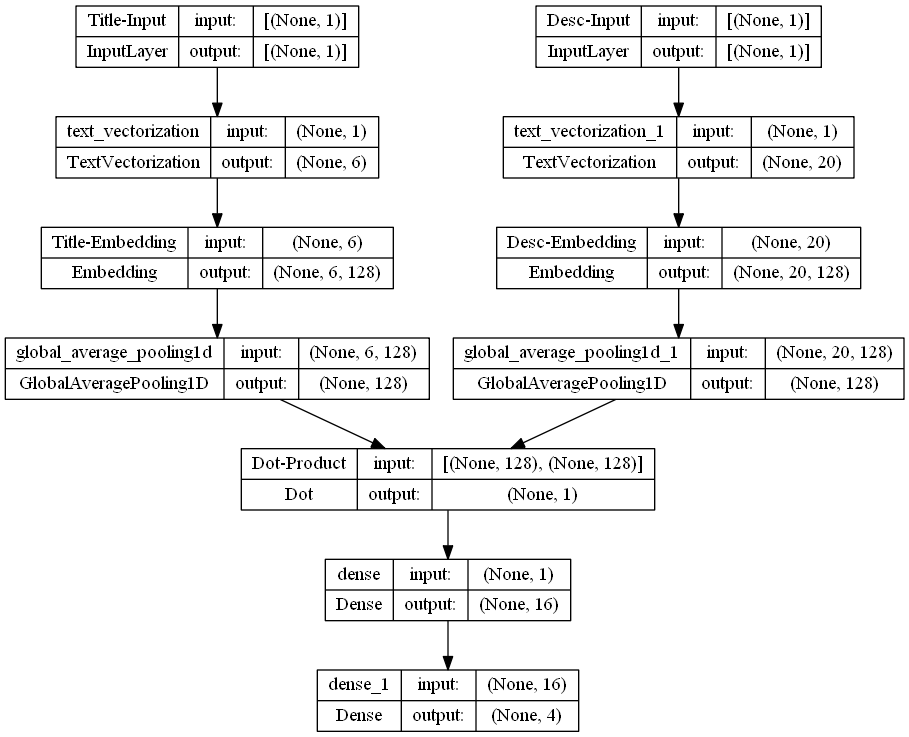

In [48]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

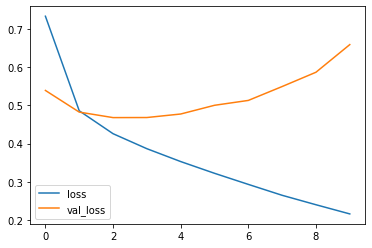

In [49]:
metrics = pd.DataFrame(model_1_hist.history)
metrics[['loss', 'val_loss']].plot();

Model 1 is seems to be overfitted. The validation loss keeps increasing.

In [50]:
y_pred_1 = model_1.predict([X_val.clean_title, X_val.clean_desc])
y_pred_1 = y_pred_1.argmax(axis=1)
print(classification_report(y_val, y_pred_1))

375/375 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.48      0.92      0.63      2971
           1       0.38      0.27      0.32      3037
           2       0.53      0.48      0.50      2981
           3       0.92      0.46      0.62      3011

    accuracy                           0.53     12000
   macro avg       0.58      0.53      0.52     12000
weighted avg       0.58      0.53      0.52     12000



Since the dataset is balanced, we can focus on the accuracy score to evaluate the model. As per classification report above, model 1 achieves an accuracy of 63%. It is not a great number obviously. Perhaps it happens due to low number of epochs.

## Model 2

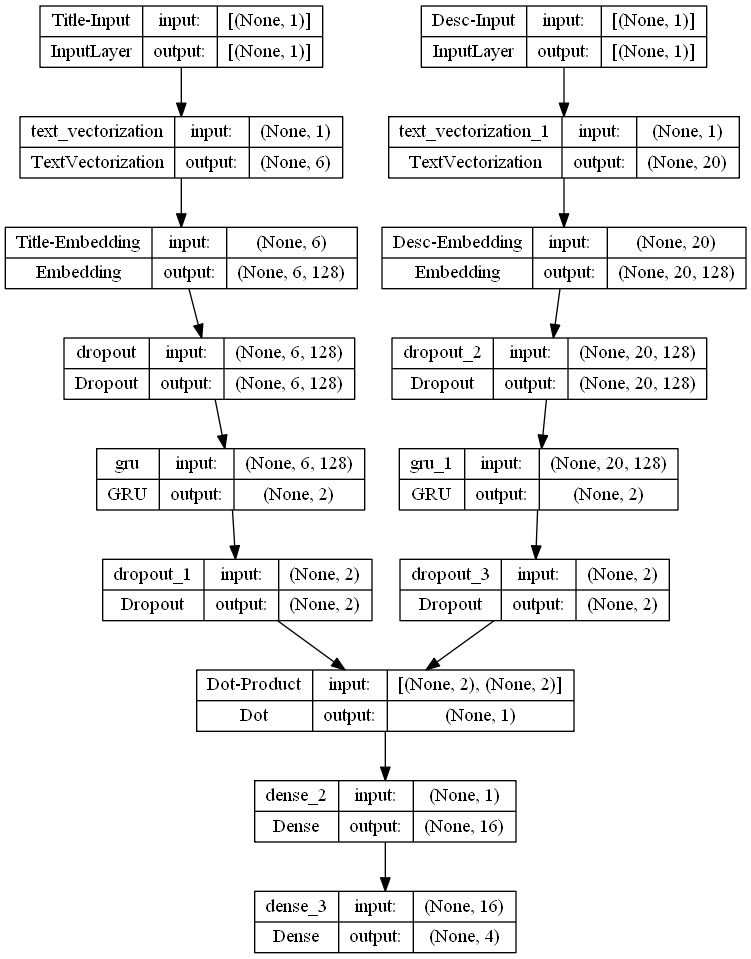

In [51]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

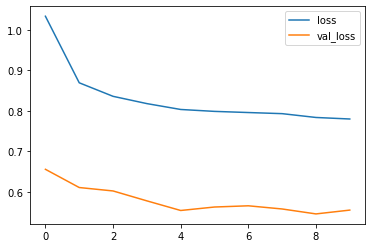

In [52]:
metrics = pd.DataFrame(model_2_hist.history)
metrics[['loss', 'val_loss']].plot();

Model 2 doesn't look very good either, according to above plot. 

In [53]:
y_pred_2 = model_2.predict([X_val.clean_title, X_val.clean_desc])
y_pred_2 = y_pred_2.argmax(axis=1)
print(classification_report(y_val, y_pred_2))

375/375 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2971
           1       0.87      0.91      0.89      3037
           2       0.75      0.81      0.78      2981
           3       0.80      0.86      0.83      3011

    accuracy                           0.83     12000
   macro avg       0.84      0.83      0.83     12000
weighted avg       0.84      0.83      0.83     12000



Model 2 has better accuracy than model 1, achieving an accuracy of 80%.

## Model 3

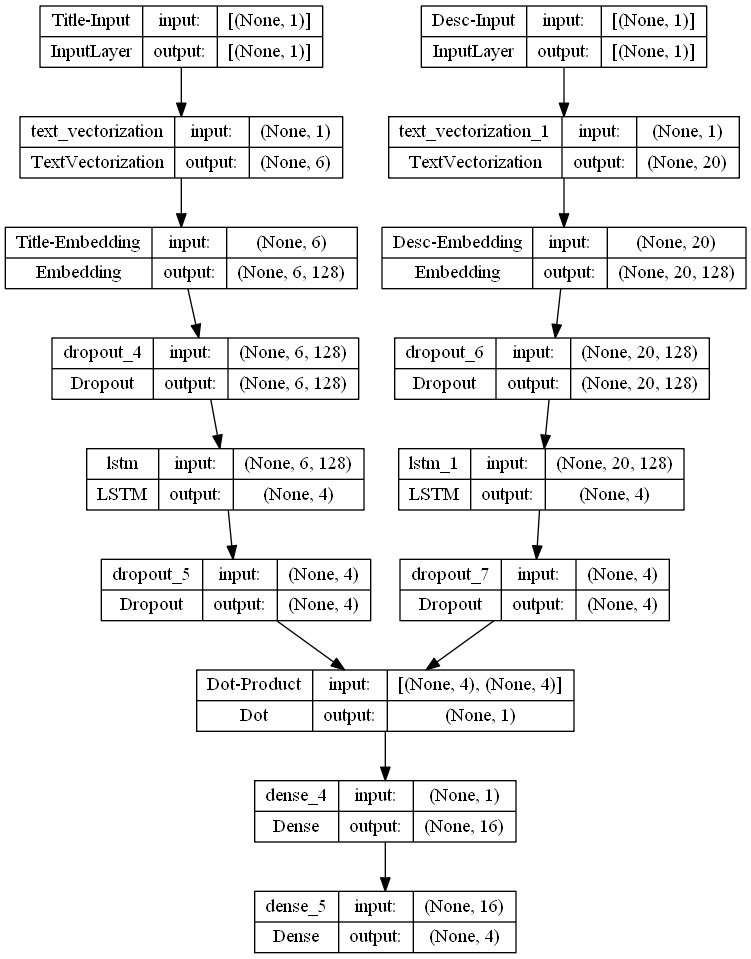

In [54]:
tf.keras.utils.plot_model(model_3, show_shapes=True)

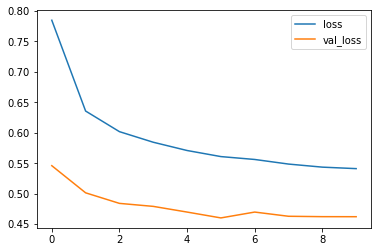

In [55]:
metrics = pd.DataFrame(model_3_hist.history)
metrics[['loss', 'val_loss']].plot();

Model 3 loss graph doesn't look very good either. It must be due to the lack of epochs.

In [56]:
y_pred_3 = model_3.predict([X_val.clean_title, X_val.clean_desc])
y_pred_3 = y_pred_3.argmax(axis=1)
print(classification_report(y_val, y_pred_3))

375/375 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      2971
           1       0.91      0.93      0.92      3037
           2       0.80      0.86      0.83      2981
           3       0.80      0.89      0.84      3011

    accuracy                           0.86     12000
   macro avg       0.87      0.86      0.86     12000
weighted avg       0.87      0.86      0.86     12000



Model 3 has even better accuracy compared to model 1 and 2. It achieves an accuracy of 85.2%.

## Comparison

In [57]:
print('Model 1 Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_1), decimals=3)))
print('Model 2 Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_2), decimals=3)))
print('Model 3 Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_3), decimals=3)))

Model 1 Accuracy: 0.53
Model 2 Accuracy: 0.834
Model 3 Accuracy: 0.858


The LSTM model (model 3) has the highest accuracy with 85.2%.

## Model Improvement

We will try to improve the LSTM model by doing trial and error.

#### 1st trial

Adding more neurons in the LSTM layer, from 4 to 8.

In [58]:
# # First trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.3)(title_emb)
# title_gru = LSTM(8)(title_do1)
# title_do2 = Dropout(0.3)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.3)(desc_emb)
# desc_gru = LSTM(8)(desc_do1)   # 8 neurons
# desc_do2 = Dropout(0.3)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [59]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [60]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 2nd trial

Reduce the number of neurons in the LSTM layer, from 4 to 2.

In [61]:
# # Second trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.3)(title_emb)
# title_gru = LSTM(2)(title_do1)
# title_do2 = Dropout(0.3)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.3)(desc_emb)
# desc_gru = LSTM(2)(desc_do1)   # 2 neurons
# desc_do2 = Dropout(0.3)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [62]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [63]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 3rd trial

Increase the dropout rate to 0.5

In [64]:
# # Third trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [65]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [66]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has improved a tiny bit. So, we will implement 0.5 of dropout rate to the next trials.

#### 4th trial

Reduce the number of neurons in Dense layer to 8.

In [67]:
# # Fourth trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(8, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [68]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [69]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 5th trial

Increase the number of neurons in Dense layer to 32.

In [70]:
# # Fifth trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(32, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [71]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [72]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 6th trial

Add an additional dense layer with 8 neurons.

In [73]:
# # Sixth trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# hidden2 = Dense(8, activation='relu')(hidden1)
# out = Dense(4, activation='softmax')(hidden2)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [74]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [75]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 7th trial

Increase the number of epochs to 20.

In [76]:
# Seventh trial
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [77]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=20,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [78]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 8th trial

Change the optimizer to adamax.

In [79]:
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adamax',
#               metrics=['accuracy'])

In [80]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [81]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 9th trial 

Change the optimizer to adagrad.

In [82]:
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='adagrad',
#               metrics=['accuracy'])

In [83]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [84]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 10th trial

Change the optimizer to nadam.

In [85]:
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='nadam',
#               metrics=['accuracy'])

In [86]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [87]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has improved a little bit.

#### 11th trial

Change the optimizer to sgd.

In [88]:
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

In [89]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [90]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### 12th trial

Change the optimizer to rmsprop.

In [91]:
# title_in = Input(shape=(1,), dtype="string", name='Title-Input')
# title_vec = text_vectorization_title(title_in)
# title_emb = embedding_title(title_vec)
# title_do1 = Dropout(0.5)(title_emb)
# title_gru = LSTM(4)(title_do1)
# title_do2 = Dropout(0.5)(title_gru)

# desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
# desc_vec = text_vectorization_desc(desc_in)
# desc_emb = embedding_desc(desc_vec)
# desc_do1 = Dropout(0.5)(desc_emb)
# desc_gru = LSTM(4)(desc_do1)   
# desc_do2 = Dropout(0.5)(desc_gru)

# prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
# hidden1 = Dense(16, activation='relu')(prod)
# out = Dense(4, activation='softmax')(hidden1)

# tuned_model = Model([title_in, desc_in], out)

# tuned_model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

In [92]:
# tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
#                          y = y_train_ohe,
#                          epochs=10,
#                          validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe))

In [93]:
# y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
# y_pred_t = y_pred_t.argmax(axis=1)
# print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))

The accuracy has not improved.

#### Result

So far, the best performing model is the one with 0.5 of dropout percentage and using nadam optimizer. 

We will run it one more time with more epochs and a callback.

In [94]:
title_in = Input(shape=(1,), dtype="string", name='Title-Input')
title_vec = text_vectorization_title(title_in)
title_emb = embedding_title(title_vec)
title_do1 = Dropout(0.5)(title_emb)
title_gru = LSTM(4)(title_do1)
title_do2 = Dropout(0.5)(title_gru)

desc_in = Input(shape=(1,), dtype="string", name='Desc-Input')
desc_vec = text_vectorization_desc(desc_in)
desc_emb = embedding_desc(desc_vec)
desc_do1 = Dropout(0.5)(desc_emb)
desc_gru = LSTM(4)(desc_do1)   
desc_do2 = Dropout(0.5)(desc_gru)

prod = Dot(name='Dot-Product', axes=1)([title_do2, desc_do2])
hidden1 = Dense(16, activation='relu')(prod)
out = Dense(4, activation='softmax')(hidden1)

tuned_model = Model([title_in, desc_in], out)

tuned_model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [95]:
# setting number of epoch and callback for early stopping
num_epoch = 30
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # early stopping set after 5 epochs

In [96]:
tuned_model_hist = tuned_model.fit(x = [X_train.clean_title, X_train.clean_desc],
                         y = y_train_ohe,
                         epochs=num_epoch,
                         validation_data=([X_val.clean_title, X_val.clean_desc], y_val_ohe), callbacks=[stop_early])

Epoch 1/30
3375/3375 [==============================] - 73s 21ms/step - loss: 0.9648 - accuracy: 0.5680 - val_loss: 0.5899 - val_accuracy: 0.8154
Epoch 2/30
3375/3375 [==============================] - 69s 21ms/step - loss: 0.8578 - accuracy: 0.6277 - val_loss: 0.5512 - val_accuracy: 0.8232
Epoch 3/30
3375/3375 [==============================] - 69s 20ms/step - loss: 0.8358 - accuracy: 0.6382 - val_loss: 0.5292 - val_accuracy: 0.8242
Epoch 4/30
3375/3375 [==============================] - 69s 20ms/step - loss: 0.8236 - accuracy: 0.6445 - val_loss: 0.5170 - val_accuracy: 0.8312
Epoch 5/30
3375/3375 [==============================] - 70s 21ms/step - loss: 0.8120 - accuracy: 0.6497 - val_loss: 0.4901 - val_accuracy: 0.8397
Epoch 6/30
3375/3375 [==============================] - 69s 21ms/step - loss: 0.8100 - accuracy: 0.6517 - val_loss: 0.5013 - val_accuracy: 0.8377
Epoch 7/30
3375/3375 [==============================] - 69s 21ms/step - loss: 0.7937 - accuracy: 0.6597 - val_loss: 0.4757 -

In [97]:
y_pred_t = tuned_model.predict([X_val.clean_title, X_val.clean_desc])
y_pred_t = y_pred_t.argmax(axis=1)
print('Tuned Model Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_t), decimals=3)))
print('Model 3 Accuracy: {}'.format(np.around(accuracy_score(y_val, y_pred_3), decimals=3)))

375/375 [==============================] - 3s 5ms/step
Tuned Model Accuracy: 0.846
Model 3 Accuracy: 0.858


As we can see above, the tuned model has improved accuracy by a significant amount. From 85.2% to 86.3% of accuracy.

---
# 9 - Model Saving

In [98]:
# model_version = "0001"
# model_name = "nlp_news_model"
# model_path = os.path.join(model_name, model_version)
# model_path

In [99]:
# tf.saved_model.save(tuned_model, model_path)

In [100]:
tuned_model.save('tuned_model')

INFO:tensorflow:Assets written to: tuned_model\assets


INFO:tensorflow:Assets written to: tuned_model\assets


---
# 10 - Model Inference

In [122]:
X_test.head()

,clean_title,clean_desc
0,fear n pension talk,union represent worker turner newall say disap...
1,race second private team set launch date human...,space com toronto canada second team rocketeer...
2,ky company win grant study peptide ap,ap company found chemistry researcher universi...
3,prediction unit help forecast wildfire ap,ap barely dawn mike fitzpatrick start shift bl...
4,calif aim limit farm relate smog ap,ap southern california smog fight agency go em...


In [127]:
y_pred_inf = tuned_model.predict([X_test.clean_title, X_test.clean_desc])
y_pred_inf = y_pred_inf.argmax(axis=1)

238/238 [==============================] - 2s 8ms/step


In [128]:
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['label-pred'])

In [129]:
print('Model prediction to new data')
final = pd.concat([y_test, y_pred_inf_df], axis=1)
final.head(30)

Model prediction to new data


,label,label-pred
0,2,2
1,3,0
2,3,3
3,3,3
4,3,3
5,3,2
6,3,0
7,3,0
8,3,3
9,3,2


The tuned model has been proved to predict the label of the new news articles.

---
# 11 - Conclusion

* We have made a model that can predict the label of the news articles. 

* The dataset that is used to create the model is the AG news dataset. In total, it has 127,600 rows and 3 columns. The columns are title, description, and label/class. There is no missing value detected.

* The news articles are classified into 4: World, Sports, Business, and Sci/Tech. Each class has the same number of articles, indicating a balanced dataset. 

* The World news articles have the longest average word count, both in title and description. They also have the longest average character count in the title.

* Data preprocessing techniques used were case folding, stopword removal, and lemmatization. Tokenization were realized using textvecotization, while for embedding was embedding layer in sklearn

* We made 3 baseline models. Model 1 incorporated Global Average Pooling 1D, Model 2 implemented GRU, and Model 3 implemented LSTM. 

* The LSTM model performed the best out of the three models, with accuracy of 85.2%.

* Then the model was improved by using dropout percentage of 0.5, changing the optimizer to nadam, and increasing the number of epochs. The tuned model has an increased accuracy of 86.3%.

* The tuned model was able to predict new news articles. The model can be further improved by tuning more hyperparameter. It will be easier to do this in automation, such as using keras tuner.

* The news classification model is very helpful especially in the news industry. It can help users to access the news articles based on the topic they are interested in.
